In [36]:
import numpy as np 
import pandas as pd
import re 
import glob
import numpy as np
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report, roc_curve, auc
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from xgboost import plot_importance
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import confusion_matrix
sns.set_style("darkgrid")
from imblearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks

In [37]:
df = pd.read_csv('ai4i2020.csv')
df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


In [38]:
df["Temp"] = df["Air temperature [K]"]*df["Process temperature [K]"]
df["Poor"] = df["Torque [Nm]"]/df["Rotational speed [rpm]"]
df["Poor2"] = df["Torque [Nm]"]/np.sqrt(df["Rotational speed [rpm]"])
df["In_Temp"] = df["Air temperature [K]"]/df["Process temperature [K]"]
df["In_Poor"] = df["Torque [Nm]"]*df["Rotational speed [rpm]"]
df["In_Poor2"] = df["Torque [Nm]"]*np.sqrt(df["Rotational speed [rpm]"])
df["Air_Sq"] = df["Air temperature [K]"]**2
df["Pro_Sq"] = df["Process temperature [K]"]**2
df["Rot_Sq"] = df["Rotational speed [rpm]"]**2
df["Tor_Sq"] = df["Torque [Nm]"]**(1/2)
df["Too_Sq"] = df["Tool wear [min]"]**(1/2)
df["Air_Sqr"] = df["Air temperature [K]"]**(1/2)
df["Pro_Sqr"] = df["Process temperature [K]"]**(1/2)
df["Rot_Sqr"] = df["Rotational speed [rpm]"]**(1/2)
df["Tor_Sqr"] = df["Torque [Nm]"]**(1/2)
df["Too_Sqr"] = df["Tool wear [min]"]**(1/2)
df["Diff_Tepm"] = np.abs(df["Air temperature [K]"]-df["Process temperature [K]"])
df["Ro_Tor_Mul"] = df["Rotational speed [rpm]"]*df["Torque [Nm]"]
df["Ro_Tor_Div"] = df["Rotational speed [rpm]"]/df["Torque [Nm]"]
df["Ro_Tor_Mul_Sqr"] = np.sqrt(df["Rotational speed [rpm]"])*np.sqrt(df["Torque [Nm]"])
df["Ro_Tor_Mul_Log"] = np.log(df["Rotational speed [rpm]"])*np.log(df["Torque [Nm]"])
df["Ro_Tor_Div_Sqr"] = np.sqrt(df["Rotational speed [rpm]"])/np.sqrt(df["Torque [Nm]"])
df["Ro_Tor_Div_Log"] = np.log(df["Rotational speed [rpm]"])/np.log(df["Torque [Nm]"])
df["Ro_Tem_Mul"] = df["Rotational speed [rpm]"]*df["Diff_Tepm"]
df["Tor_Tem_Div"] = df["Diff_Tepm"]/df["Torque [Nm]"]
df

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,...,Too_Sqr,Diff_Tepm,Ro_Tor_Mul,Ro_Tor_Div,Ro_Tor_Mul_Sqr,Ro_Tor_Mul_Log,Ro_Tor_Div_Sqr,Ro_Tor_Div_Log,Ro_Tem_Mul,Tor_Tem_Div
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,...,0.000000,10.5,66382.8,36.238318,257.648598,27.597990,6.019827,1.955698,16285.5,0.245327
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,...,1.732051,10.5,65190.4,30.410367,255.324108,27.804494,5.514560,1.890393,14784.0,0.226782
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,...,2.236068,10.4,74001.2,30.323887,272.031616,28.515994,5.506713,1.874866,15579.2,0.210526
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,...,2.645751,10.4,56603.5,36.278481,237.914901,26.717609,6.023162,1.976858,14903.2,0.263291
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,...,3.000000,10.5,56320.0,35.200000,237.318352,26.744101,5.932959,1.965346,14784.0,0.262500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,M24855,M,298.8,308.4,1604,29.5,14,0,0,...,3.741657,9.6,47318.0,54.372881,217.527010,24.977666,7.373797,2.180675,15398.4,0.325424
9996,9997,H39410,H,298.9,308.4,1632,31.8,17,0,0,...,4.123106,9.5,51897.6,51.320755,227.810448,25.591615,7.163851,2.138353,15504.0,0.298742
9997,9998,M24857,M,299.0,308.6,1645,33.4,22,0,0,...,4.690416,9.6,54943.0,49.251497,234.399232,25.982596,7.017941,2.110696,15792.0,0.287425
9998,9999,H39412,H,299.0,308.7,1408,48.5,25,0,0,...,5.000000,9.7,68288.0,29.030928,261.319728,28.141049,5.388036,1.867785,13657.6,0.200000


In [78]:
df_correlation = df.corr()

In [79]:
df_correlation

,UDI,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,...,Too_Sqr,Diff_Tepm,Ro_Tor_Mul,Ro_Tor_Div,Ro_Tor_Mul_Sqr,Ro_Tor_Mul_Log,Ro_Tor_Div_Sqr,Ro_Tor_Div_Log,Ro_Tem_Mul,Tor_Tem_Div
UDI,1.000000,0.117428,0.324428,-0.006615,0.003207,-0.010702,-0.022892,0.009154,-0.022215,-0.023557,...,-0.009559,0.246210,0.004150,-0.017232,0.004691,0.006271,-0.009910,-0.011022,0.156260,0.052204
Air temperature [K],0.117428,1.000000,0.876107,0.022670,-0.013778,0.013853,0.082556,0.009955,0.137831,0.003470,...,0.011623,-0.699583,-0.011474,0.013946,-0.012297,-0.015658,0.018425,0.016199,-0.443697,-0.177330
Process temperature [K],0.324428,0.876107,1.000000,0.019277,-0.014061,0.013488,0.035946,0.007315,0.056933,-0.003355,...,0.012105,-0.268413,-0.010952,0.008156,-0.010992,-0.013064,0.014153,0.012140,-0.162538,-0.064778
Rotational speed [rpm],-0.006615,0.022670,0.019277,1.000000,-0.875027,0.000223,-0.044188,0.010389,-0.121241,0.123018,...,-0.001445,-0.016727,-0.805584,0.891429,-0.830244,-0.915022,0.969749,0.953371,0.748861,0.874662
Torque [Nm],0.003207,-0.013778,-0.014061,-0.875027,1.000000,-0.003093,0.191321,-0.014662,0.142610,0.083781,...,-0.001932,0.006690,0.978828,-0.750183,0.976971,0.970924,-0.898900,-0.903076,-0.661408,-0.806336
Tool wear [min],-0.010702,0.013853,0.013488,0.000223,-0.003093,1.000000,0.105448,0.115792,-0.001287,-0.009334,...,0.975794,-0.007689,-0.003193,0.000340,-0.003048,-0.002383,0.001092,0.001648,-0.004020,0.000087
Machine failure,-0.022892,0.082556,0.035946,-0.044188,0.191321,0.105448,1.000000,0.362904,0.575800,0.522812,...,0.085414,-0.111676,0.176039,0.063317,0.150588,0.103129,-0.026766,-0.032107,-0.099039,-0.011622
TWF,0.009154,0.009955,0.007315,0.010389,-0.014662,0.115792,0.362904,1.000000,-0.007332,0.008577,...,0.093984,-0.009048,-0.016586,0.009909,-0.016683,-0.015362,0.012592,0.012712,0.003279,0.010601
HDF,-0.022215,0.137831,0.056933,-0.121241,0.142610,-0.001287,0.575800,-0.007332,1.000000,0.018443,...,0.000119,-0.191015,0.116556,-0.075962,0.112843,0.114099,-0.105239,-0.105983,-0.201735,-0.122613
PWF,-0.023557,0.003470,-0.003355,0.123018,0.083781,-0.009334,0.522812,0.008577,0.018443,1.000000,...,-0.011139,-0.011904,0.089191,0.253579,0.051787,-0.026780,0.139507,0.133304,0.083973,0.173657


In [9]:
df_selected  =  ['Air temperature [K]','Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]','Tool wear [min]']

In [10]:
# Feature Engineering  
def power_f(data) :
    return data*data

def root_f(data) :
    return data**(0.5)
df[['Air temperature [K]_2' , 'Process temperature [K]_2' , 'Rotational speed [rpm]_2' ,'Torque [Nm]_2','Tool wear [min]_2']] = df[df_selected].apply(power_f)
df[['Air temperature [K]_rt' , 'Process temperature [K]_rt' , 'Rotational speed [rpm]_rt' ,'Torque [Nm]_rt','Tool wear [min]_rt']] = df[df_selected].apply(root_f)
df['Rotation_Torque'] = df['Rotational speed [rpm]'] * df['Torque [Nm]']
df['Temp_diff'] =  df['Process temperature [K]'] - df['Process temperature [K]']
df

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,...,Rotational speed [rpm]_2,Torque [Nm]_2,Tool wear [min]_2,Air temperature [K]_rt,Process temperature [K]_rt,Rotational speed [rpm]_rt,Torque [Nm]_rt,Tool wear [min]_rt,Rotation_Torque,Temp_diff
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,...,2405601,1831.84,0,17.265573,17.567015,39.382737,6.542171,0.000000,66382.8,0.0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,...,1982464,2143.69,9,17.268468,17.569861,37.523326,6.804410,1.732051,65190.4,0.0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,...,2244004,2440.36,25,17.265573,17.564168,38.704005,7.028513,2.236068,74001.2,0.0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,...,2053489,1560.25,49,17.268468,17.567015,37.854986,6.284903,2.645751,56603.5,0.0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,...,1982464,1600.00,81,17.268468,17.569861,37.523326,6.324555,3.000000,56320.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,M24855,M,298.8,308.4,1604,29.5,14,0,0,...,2572816,870.25,196,17.285832,17.561321,40.049969,5.431390,3.741657,47318.0,0.0
9996,9997,H39410,H,298.9,308.4,1632,31.8,17,0,0,...,2663424,1011.24,289,17.288725,17.561321,40.398020,5.639149,4.123106,51897.6,0.0
9997,9998,M24857,M,299.0,308.6,1645,33.4,22,0,0,...,2706025,1115.56,484,17.291616,17.567015,40.558600,5.779273,4.690416,54943.0,0.0
9998,9999,H39412,H,299.0,308.7,1408,48.5,25,0,0,...,1982464,2352.25,625,17.291616,17.569861,37.523326,6.964194,5.000000,68288.0,0.0


In [40]:
df_c  =  df.copy()

In [41]:
x =  df_c.drop(columns = ['UDI','Product ID','Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF','Type'], axis =  1   )
y = df_c['Machine failure']

In [44]:
# ## Feature importtance
from sklearn.datasets import make_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier

def f_importance(X,y) :
    model_impor =  DecisionTreeClassifier()
    rf  =  RandomForestRegressor(n_estimators=100)
    rf.fit(X,y)
    # check type value 
    print(type(rf.feature_importances_))
    feature_score = rf.feature_importances_
    
    df_feature_score =  pd.DataFrame(feature_score, index = list(X.columns), columns= ['Feature_importance']).sort_values(by = 'Feature_importance' , ascending = False)
    
    return df_feature_score
y =  df_c['Machine failure']
feature=f_importance(x,y)
feature = feature[feature['Feature_importance'] > 0.03]

<class 'numpy.ndarray'>


In [46]:
feature

,Feature_importance
Ro_Tem_Mul,0.163618
In_Poor,0.105818
Ro_Tor_Mul,0.095505
Ro_Tor_Mul_Sqr,0.086547
Tor_Tem_Div,0.065444
In_Temp,0.045805
In_Poor2,0.045403
Rotational speed [rpm],0.041602
Rot_Sqr,0.040432
Tool wear [min],0.038895


In [47]:
col_x = list(feature.index)

In [48]:
x  = x[col_x]  
y
df_new = pd.concat([x,y],axis = 1)  

In [49]:
df_new

,Ro_Tem_Mul,In_Poor,Ro_Tor_Mul,Ro_Tor_Mul_Sqr,Tor_Tem_Div,In_Temp,In_Poor2,Rotational speed [rpm],Rot_Sqr,Tool wear [min],Too_Sq,Rot_Sq,Too_Sqr,Machine failure
0,16285.5,66382.8,66382.8,257.648598,0.245327,0.965975,1685.581158,1551,39.382737,0,0.000000,2405601,0.000000,0
1,14784.0,65190.4,65190.4,255.324108,0.226782,0.965986,1737.329997,1408,37.523326,3,1.732051,1982464,1.732051,0
2,15579.2,74001.2,74001.2,272.031616,0.210526,0.966288,1911.977845,1498,38.704005,5,2.236068,2244004,2.236068,0
3,14903.2,56603.5,56603.5,237.914901,0.263291,0.966299,1495.271965,1433,37.854986,7,2.645751,2053489,2.645751,0
4,14784.0,56320.0,56320.0,237.318352,0.262500,0.965986,1500.933043,1408,37.523326,9,3.000000,1982464,3.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,15398.4,47318.0,47318.0,217.527010,0.325424,0.968872,1181.474079,1604,40.049969,14,3.741657,2572816,3.741657,0
9996,15504.0,51897.6,51897.6,227.810448,0.298742,0.969196,1284.657028,1632,40.398020,17,4.123106,2663424,4.123106,0
9997,15792.0,54943.0,54943.0,234.399232,0.287425,0.968892,1354.657226,1645,40.558600,22,4.690416,2706025,4.690416,0
9998,13657.6,68288.0,68288.0,261.319728,0.200000,0.968578,1819.881315,1408,37.523326,25,5.000000,1982464,5.000000,0


In [50]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2,  random_state= 123)

In [51]:
X_test.shape

(2000, 13)

In [52]:
random_over = RandomOverSampler(random_state=123)
random_over.fit(X_train, y_train)
X_oversampled, y_oversampled = random_over.fit_resample(X_train, y_train)
df_oversampled = pd.concat([pd.DataFrame(data=X_oversampled),pd.DataFrame(data=y_oversampled)], axis=1, sort=False)

In [53]:
#X_train
sm = SMOTE(random_state=123)
sm.fit(X_train, y_train)
X_SMOTE, y_SMOTE = sm.fit_resample(X_train, y_train)
df_SMOTE = pd.concat([pd.DataFrame(data=X_SMOTE),pd.DataFrame(data=y_SMOTE)], axis=1, sort=False)

In [21]:
df_SMOTE.head()

,Rotation_Torque,Air temperature [K]_2,Air temperature [K],Air temperature [K]_rt,Process temperature [K]_2,Tool wear [min]_rt,Tool wear [min],Process temperature [K]_rt,Tool wear [min]_2,Process temperature [K],Machine failure
0,64195.3,88625.29,297.7,17.253985,95357.44,9.797959,96,17.572706,9216,308.8,0
1,48412.0,89940.01,299.9,17.317621,96348.16,13.228757,175,17.618172,30625,310.4,0
2,56710.5,87202.09,295.3,17.184295,93452.49,13.747727,189,17.484279,35721,305.7,0
3,56569.2,90540.81,300.9,17.346469,96472.36,13.638182,186,17.623847,34596,310.6,0
4,60838.8,89940.01,299.9,17.317621,95666.49,10.295630,106,17.586927,11236,309.3,0


In [54]:
X_train = X_oversampled
y_train = y_oversampled

In [55]:
y_train.shape

(15474,)

In [56]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)

In [72]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from keras.models import Sequential
from keras.layers import Dense 
from keras.layers import Dense
from keras.layers import Dropout
from tensorflow.keras.optimizers import SGD,Adagrad
### created model  ###
model = Sequential()  
model.add(Dense(128, kernel_initializer='uniform',activation='relu',input_dim= X_train.shape[1]))
#model.add(Dense(256,activation='relu'))
#model.add(Dense(128, kernel_initializer='uniform',activation='relu'))
#model.add(Dropout(0.2))
model.add(Dense(64, kernel_initializer='uniform',activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, kernel_initializer='uniform',activation='relu')) 
model.add(Dropout(0.2))
model.add(Dense(1, kernel_initializer='uniform',activation='sigmoid')) #sigmoid , tanh , 
model.compile(optimizer='Nadam', loss='binary_crossentropy', metrics=['AUC']) #sgd adam Adagrad
model_fit = model.fit(x = X_train ,y = y_train, epochs = 50, batch_size=32) #,validation_data=(x_test ,y_test)
#y_pred = model.predict(X_test)

Epoch 1/50
484/484 [==============================] - 2s 3ms/step - loss: 0.3093 - auc: 0.9436
Epoch 2/50
484/484 [==============================] - 1s 2ms/step - loss: 0.2053 - auc: 0.9728
Epoch 3/50
484/484 [==============================] - 1s 3ms/step - loss: 0.1926 - auc: 0.9755
Epoch 4/50
484/484 [==============================] - 1s 3ms/step - loss: 0.1754 - auc: 0.9798
Epoch 5/50
484/484 [==============================] - 1s 2ms/step - loss: 0.1620 - auc: 0.9829
Epoch 6/50
484/484 [==============================] - 1s 2ms/step - loss: 0.1504 - auc: 0.9854
Epoch 7/50
484/484 [==============================] - 1s 3ms/step - loss: 0.1424 - auc: 0.9868
Epoch 8/50
484/484 [==============================] - 1s 2ms/step - loss: 0.1366 - auc: 0.9878
Epoch 9/50
484/484 [==============================] - 1s 2ms/step - loss: 0.1312 - auc: 0.9889
Epoch 10/50
484/484 [==============================] - 1s 2ms/step - loss: 0.1230 - auc: 0.9903
Epoch 11/50
484/484 [============================

In [73]:
sc = StandardScaler()
X_test = sc.fit_transform(X_test)
y_pred = model.predict(X_test)

In [74]:
#train  model  accuracy 
y_pred_train = model.predict(X_train)

In [75]:
# show with  class  1 only  
from sklearn import metrics
auc = metrics.roc_auc_score(y_test, y_pred)
auc

0.9539644654776233

In [65]:
## train  

# show with  class  1 only  
from sklearn import metrics
auc = metrics.roc_auc_score(y_train, y_pred_train)
auc

0.9973686113613986

In [66]:
y_expect = y_pred > 0.5
cm = confusion_matrix(y_test, y_expect)
cm

array([[1380,  544],
       [   3,   73]], dtype=int64)

In [67]:
# show with  class  1 only  
from sklearn import metrics
auc = metrics.roc_auc_score(y_test, y_pred)
auc

0.9557938505306927

In [68]:
fpr_test, tpr_test, _ = roc_curve(y_test,  y_expect)

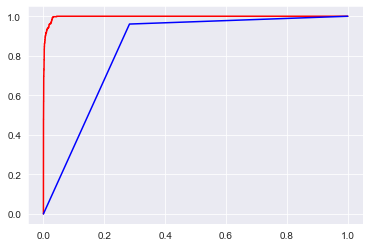

In [69]:
fpr_train, tpr_train, _ = roc_curve(y_train,  y_pred_train)
auc_train = roc_auc_score(y_train, y_pred_train)
plt.plot(fpr_train,tpr_train, color='red', label='undersampled - train , auc='+str(auc_train))
plt.plot(fpr_test,tpr_test, color='Blue', label='undersampled - test , auc='+str(auc))

In [178]:
cm

array([[1911,   13],
       [  40,   36]], dtype=int64)

In [215]:
print(classification_report(y_test, y_expect))

              precision    recall  f1-score   support

           0       1.00      0.76      0.86      1924
           1       0.13      0.95      0.23        76

    accuracy                           0.77      2000
   macro avg       0.57      0.85      0.55      2000
weighted avg       0.96      0.77      0.84      2000



In [181]:
tn, fp, fn, tp  = confusion_matrix(y_test, y_expect).ravel()
print('tn:',tn , ' fp:',fp, ' fn:',fn, ' tp: ',tp)  ##  fp predict  use to not -use 
percision  =  tp/(tp+fp) 
recall   =  tp/(tp+fn)
print('Percision', percision)
print('Recall', recall)

tn: 1911  fp: 13  fn: 40  tp:  36
Percision 0.7346938775510204
Recall 0.47368421052631576


In [47]:
print(classification_report(y_test, y_expect))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1946
           1       0.58      0.41      0.48        54

    accuracy                           0.98      2000
   macro avg       0.78      0.70      0.73      2000
weighted avg       0.97      0.98      0.97      2000



In [ ]:
from sklearn.metrics import confusion_matrix

print('#'* 20 + " Regression Model with under sampling "+ '#'*20 )
tn, fp, fn, tp  = confusion_matrix(expected_y, predicted_y).ravel()
print('tn:',tn , ' fp:',fp, ' fn:',fn, ' tp: ',tp)  ##  fp predict  use to not -use 
cm = confusion_matrix(expected_y, predicted_y)